In [ ]:
# This notebook demonstrates usage of our estimator.
# We will re-create Figure 2 from the paper

In [1]:
import numpy as np
import scipy
from submission_code import KS_test, get_counts, estimateEntireLine, estimateZeta_FWER, getSamples
from multiprocessing import Pool
import matplotlib.pyplot as plt

In [2]:
# Set this based on your machine. This determines how parallelized the FWER computations are
# Note there is a separate setting for parallelizing our estimator in ``submission_code.py''
NUM_CORES = 10

[[0.        ]
 [0.        ]
 [0.        ]
 ...
 [2.67655459]
 [1.93706085]
 [2.45272609]]


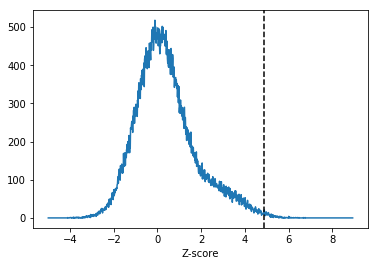

z-score would need to be at least 4.89163847571478 to reject the null
357 nulls rejected, 0.357 %


In [3]:
# Gaussian noise with variance 1
n = 100000
sigmaSquared = 1
discretization = 1000
alpha = 0.05

# Define the mixing distribution nu*
dist = [scipy.stats.bernoulli(0),  # The null hypothesis; mean is always zero
         scipy.stats.beta(a=8, b=4, scale=4)]
prop = [0.85,
          0.15]

# Draw samples X_i, which are z-scores
obs, grid = getSamples(n, prop, dist, discretization, sigmaSquared)
counts = get_counts(obs, grid)

# Plot the samples
plt.plot(grid, counts)
plt.xlabel("Z-score")

# Compute and plot the critical value for Bonferroni correction
fwer_cutoff = scipy.stats.norm.ppf((1-alpha/n), scale=1)
plt.axvline(x=fwer_cutoff, ymin=0, ymax=1, color='k', linestyle='--', label="Bonferroni\ncorrected\ncritical value")
plt.show()

print("z-score would need to be at least", fwer_cutoff, "to reject the null")
numRejected = np.sum([x > fwer_cutoff for x in obs])
print(numRejected, "nulls rejected,", 100*numRejected/n, "%")

In [4]:
# Estimate the number of hypotheses above each effect size, for a user-specified set of effect sizes
# Don't have the patience? Decrease the "discretization" in the previous cell to 500. The results will be less
#   accurate, but the optimization goes much faster.
# If you only have one core, you can turn "verbose" to True. With multiple cores, all the verbose output is
#   interleaved.
gammas = list(np.linspace(0, 3, 30)) + [5]
zetaHats = estimateEntireLine(obs=obs, 
                          tolerance=0.01,
                          alpha=alpha,
                          hypTest=KS_test,
                          grid=grid,
                          gammas=gammas, 
                          sigmaSquared=sigmaSquared, 
                          verbose=False,
                         parallel=True)

In [5]:
# Compare to FWER: At every effect size, see how many hypotheses can be rejected as significantly above that effect
jobs = [(obs, gamma, alpha, sigmaSquared ) for gamma in gammas]
with Pool(NUM_CORES) as p:
    zetaHats_FWER = p.starmap(estimateZeta_FWER, jobs)

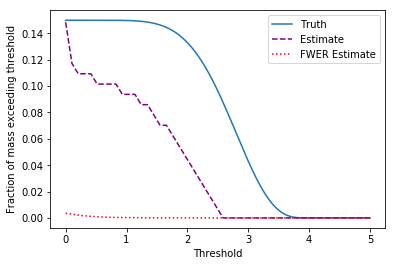

In [6]:
# Plot our estimate, the FWER estimate, and the truth
plottingGrid = np.linspace(0, max(gammas), 500)
plt.plot(plottingGrid, sum(np.array([p-p*c.cdf(plottingGrid) for (p, c) in zip(prop[1:], dist[1:])])), label="Truth")
plt.plot(gammas, zetaHats, label="Estimate", color="purple", linestyle='--')
plt.plot(gammas, zetaHats_FWER, label="FWER Estimate", color="red", linestyle=":")
plt.legend(loc="upper right")
plt.ylabel("Fraction of mass exceeding threshold")
plt.xlabel("Threshold")
plt.show()

experiment will be designed to identify effects above 2.0689655172413794
and will recover at least 0.0390625 discoveries
Taking 8 replicates
[[0.        ]
 [0.        ]
 [0.        ]
 ...
 [1.46029319]
 [2.02267427]
 [2.92147321]]
14207


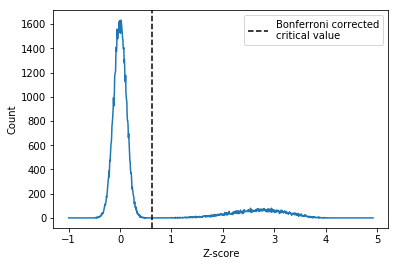

In [11]:
# Step 3: Experimental Design

# The 20th index corresponds to gamma = 2.06, and is what we used in the paper
# You can choose your own index. For an even more interactive experience, choose
# it based on the results from the previous cell!
gap = gammas[20] # The effect size we would like to find
zetaGuaranteed = zetaHats[20] # The zeta we are guaranteed
print("experiment will be designed to identify effects above", gap)
print("and will recover at least", zetaGuaranteed, "discoveries")

# Draw from the same distribution, with more replicates
numReplicates = int(np.log(n)*np.log(1/zetaGuaranteed)/(gap**2))
print("Taking", numReplicates, "replicates")
obs, grid = getSamples(n, prop, dist, discretization=1000, sigmaSquared=1/numReplicates, padding=1)
fwer_cutoff = scipy.stats.norm.ppf(1-alpha/n, scale=np.sqrt(1/numReplicates))
discoveries = np.array([x for x in obs if x > fwer_cutoff])
print(len(discoveries))

plt.plot(grid, get_counts(obs, grid))
plt.xlabel("Z-score")
plt.ylabel(r'Count')
fwer_cutoff = scipy.stats.norm.ppf((1-alpha/n), scale=1/numReplicates)
plt.axvline(x=fwer_cutoff, ymin=0, ymax=1, color='k', linestyle='--', label="Bonferroni corrected\ncritical value")
plt.legend()
plt.show()